In [743]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

sns.set_style('ticks')

In [744]:
INPUT_DIR = '../input/titanic/'
OUTPUT_DIR = './'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [745]:
train_df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22,38,26,35,35
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,A/5 21171,PC 17599,STON/O2. 3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [746]:
#report = ProfileReport(train_df)
#report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

Text(0.5, 1.0, 'Age')

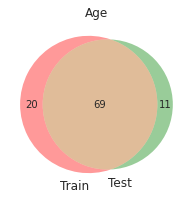

In [747]:
c = 'Age'

fig, ax = plt.subplots(figsize=(5, 3))
venn2(
    subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
    set_labels=('Train', 'Test'),
    ax=ax
)
ax.set_title(c)

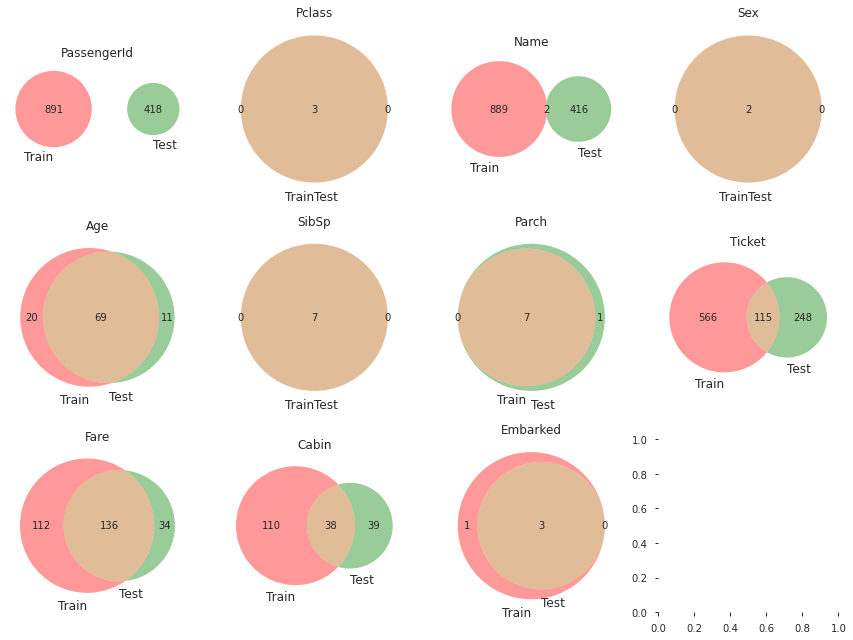

In [748]:
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)

fig.tight_layout()

In [749]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [750]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
   
    return output_df

def create_continuous_features(input_df):
    input_df = preprocess(input_df)
    use_columns = [
        # 連続変数
        "SibSp",
        "Parch",
        "Age",
        "Fare",
    ]
    return input_df[use_columns].copy()

In [751]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [752]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

In [753]:
def create_boolean_feature(input_df):
    output_df = pd.DataFrame()
    
    texts = [
    ]
    
    return output_df

In [754]:
create_boolean_feature(train_df).sum()

Series([], dtype: float64)

In [755]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py

from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)
        

In [756]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        #create_boolean_feature
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [757]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

 50%|█████     | 1/2 [00:00<00:00, 270.48it/s]

create create_continuous_features 0.002[s]
create create_boolean_feature 0.000[s]


AssertionError: create_boolean_feature

In [ ]:
assert len(test_feat_df) == len(test_df)

In [ ]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_log_error

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=10):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        
        # global sales はゼロ以下になるわけがないので 0 以下は 0 に丸める
        pred_i = np.where(pred_i < 0, 0, pred_i)
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} RMSLE: {mean_squared_log_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_log_error(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [ ]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 6, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = train_df['Survived'].values

In [ ]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [ ]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

In [ ]:
y

In [ ]:
sns.distplot(y)

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

In [ ]:
fig, ax = visualize_importance(models, train_feat_df)

In [ ]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.where(pred < 0, 0, pred)
pred

In [ ]:
pred_df=[]
for i in range(len(pred)):
    if pred[i] < 0.5:
        pred_df.append(0)
    else:
        pred_df.append(1)
pred_df

In [ ]:
my_submit0 = ['PassengerId']
my_submit1 = ['Survived']

for i in range(0, len(pred_df)):
    my_submit0.append(str(892+i))
    my_submit1.append(str(pred_df[i]))

my_submit=[]

my_submit.append(my_submit0)
my_submit.append(my_submit1)

my_submit2=np.transpose(my_submit)
my_submit2

In [ ]:
my_submit3 = pd.DataFrame(my_submit2)
my_submit3.to_csv(os.path.join(OUTPUT_DIR,'titanic_submission.csv'), index=False, header=False )

In [ ]:
my_submit3

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot(np.log1p(oof), label='Out Of Fold')
ax.legend()
ax.grid()